# Import Required Libraries

In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2023-04-23 21:47:26.756076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 21:47:27.129433: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 21:47:27.215336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/madhavm0706/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-23 21:47:27.215352

# Select Randomness

In [3]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# View the dataset

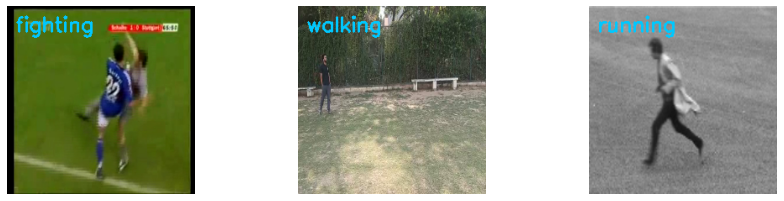

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes in our dataset.
all_classes_names = os.listdir('Dataset')
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(range(len(all_classes_names)), 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
  
    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


# Set Dataset Variables

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing our custom dataset. 
DATASET_DIR = "Dataset"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["fighting", "walking", "running"]

# Data pre-processing

In [6]:
def frames_extraction(video_path):
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)


    for frame_counter in range(SEQUENCE_LENGTH):

      
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) 
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [7]:
def create_dataset():
 

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
       
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
      
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: fighting
Extracting Data of Class: walking
Extracting Data of Class: running


In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# Model Creation LRCN (Long-term Recurrent Convolutional Network)

In [11]:
def create_LRCN_model():


    model = Sequential()
    
    # Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [12]:
model = create_LRCN_model()

2023-04-23 21:55:44.693460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/madhavm0706/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-23 21:55:44.694518: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 21:55:44.695563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (madhavm0706-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-04-23 21:55:44.703845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 16, 16, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4, 4, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 4, 4, 128)    7

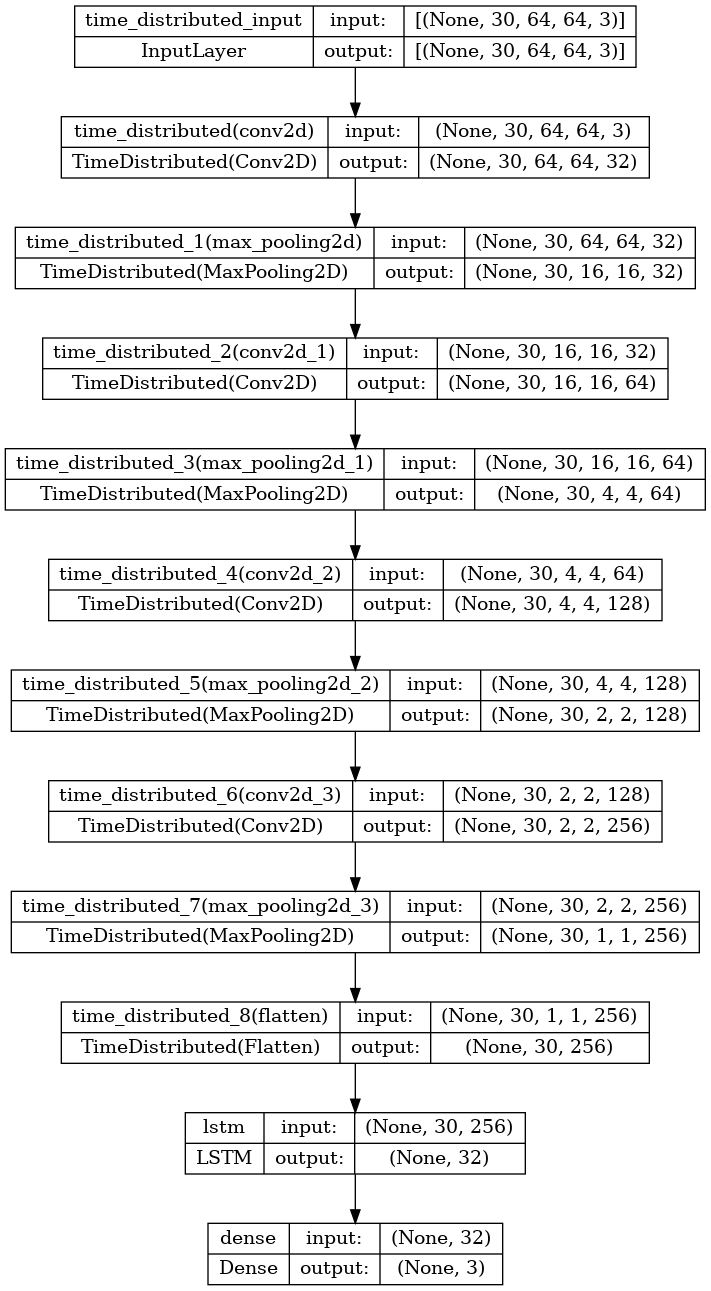

In [13]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

# Model Training

In [14]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/70
77/77 [==============================] - 7s 68ms/step - loss: 0.8958 - accuracy: 0.5850 - val_loss: 0.5620 - val_accuracy: 0.6863
Epoch 2/70
77/77 [==============================] - 5s 69ms/step - loss: 0.4928 - accuracy: 0.7386 - val_loss: 0.4322 - val_accuracy: 0.8039
Epoch 3/70
77/77 [==============================] - 5s 70ms/step - loss: 0.5081 - accuracy: 0.7320 - val_loss: 0.4113 - val_accuracy: 0.8137
Epoch 4/70
77/77 [==============================] - 5s 66ms/step - loss: 0.4691 - accuracy: 0.7680 - val_loss: 0.3605 - val_accuracy: 0.8235
Epoch 5/70
77/77 [==============================] - 5s 67ms/step - loss: 0.3470 - accuracy: 0.8072 - val_loss: 0.4349 - val_accuracy: 0.7255
Epoch 6/70
77/77 [==============================] - 5s 66ms/step - loss: 0.3435 - accuracy: 0.8170 - val_loss: 0.2878 - val_accuracy: 0.8529
Epoch 7/70
77/77 [==============================] - 5s 66ms/step - loss: 0.3346 - accuracy: 0.7843 - val_loss: 0.3018 - val_accuracy: 0.8529
Epoch 8/70
77

# Save Model

In [15]:
# Save your Model.
model.save("HAD_LRCN_Model.h5")

# Plot Loss and Accuracy Graphs while Training

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
   
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Accuracy on Test Dataset

In [26]:
# Calculate Accuracy On Test Dataset
acc = 0
y_pred=[]
y_true=[]
for i in range(len(features_test)):
    predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
    y_pred.append(predicted_label)
    actual_label = np.argmax(labels_test[i])
    y_true.append(actual_label)
    if predicted_label == actual_label:
        acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 21ms/step
Accuracy = 91.8


False Negatives:
Class 0: 1
Class 1: 5
Class 2: 2


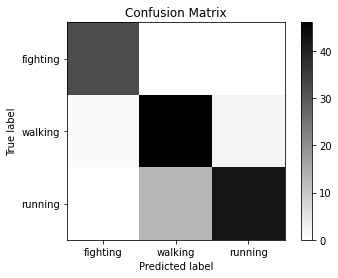

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Compute false negatives for each class
num_classes = cm.shape[0]
false_negatives = []
for i in range(num_classes):
    fn = np.sum(cm[i, :]) - cm[i, i]
    false_negatives.append(fn)

# Print false negatives for each class
print('False Negatives:')
for i in range(num_classes):
    print('Class {}: {}'.format(i, false_negatives[i]))


# Plot confusion matrix
plt.imshow(cm, cmap='binary')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(3),  ["fighting", "walking", "running"])
plt.yticks(np.arange(3),  ["fighting", "walking", "running"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [24]:
from sklearn.metrics import average_precision_score


# Compute average precision for each class
num_classes = len(np.unique(y_true))
average_precisions = []
for i in range(num_classes):
    y_true_i = [1 if y == i else 0 for y in y_true]
    y_pred_i = [1 if y == i else 0 for y in y_pred]
    ap_i = average_precision_score(y_true_i, y_pred_i)
    average_precisions.append(ap_i)

# Compute mean average precision
map = sum(average_precisions) / num_classes

# Print mean average precision
print('MAP: {:.4f}'.format(map))


MAP: 0.8494
